<a href="https://colab.research.google.com/github/tony-wade/qiskit-related/blob/main/Quantum_Circuit_Design_for_Symmetric_Encryption_Decryption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

這個專案主要聚焦於兩個方面：

1. Feistel 網路結構新解
我開發了一個全新的 Feistel 網路架構（Novel Ansatz）。Feistel 結構是許多經典密碼的基石（像 DES），我的目標是透過這個新的設計理念，嘗試在保持加解密對稱性的同時，找到一種更高效、更抗攻擊的數據混合方式。

2. Simon 密碼安全性洞察:
對輕量級密碼 Simon 進行了深入分析，使用 已知明文攻擊 配合 Optimizers 對其量子變分電路形式做逼近。


結果指出了 Simon 在低輪數實例中潛在的安全性弱點或漏洞，若用合適的optimization method 應該會更明顯。

In [ ]:
!jupyter nbconvert --to python /content/drive/MyDrive/Colab_Notebooks/NeuralNet/SPSA.ipynb
!jupyter nbconvert --to python /content/drive/MyDrive/Colab_Notebooks/NeuralNet/GuidedSA.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab_Notebooks/NeuralNet/SPSA.ipynb to python
[NbConvertApp] Writing 4737 bytes to /content/drive/MyDrive/Colab_Notebooks/NeuralNet/SPSA.py
[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab_Notebooks/NeuralNet/GuidedSA.ipynb to python
[NbConvertApp] Writing 36885 bytes to /content/drive/MyDrive/Colab_Notebooks/NeuralNet/GuidedSA.py


## Import

In [ ]:
!pip install qiskit==1.4.2
!pip install qiskit-machine-learning
!pip install pylatexenc

from IPython.display import clear_output  # 清除輸出
clear_output()

In [ ]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, TensorDataset
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Pauli, SparsePauliOp

import sys
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/NeuralNet')
from SPSA import SPSA
from GuidedSA import GuidedSA, MultiMethodSampler, SharkTeethAnnealing, PiecewiseAnnealing

## The Math Behind Cryptography

詳見: https://engineering.purdue.edu/kak/compsec/NewLectures/Lecture7.pdf

.
> 模算數 n 中的**餘數集合(set of residues) = Zn**, 為一**交換環(Commutative Ring)**, 比一般環還多遵守**乘法交換律**

(Abelian group = commutative group 即滿足運算交換律的結構)
```
4+5 = 3 (mod 6) is in Z6
4*5 = 3 (mod 6) is in Z6
```



  For Zn = {0,1,..,k,..,n-1}, k 的加法反元素 = n-k, 但**乘法反元素在 n 與 k 不互質時則不存在唯一** (有零因子)

    2*x (mod 4) = 2*y (mod 4), DOESN'T imply x = y (mod 4)
    (because 2&4 is not relatively prime i.e. gcd(2,4) != 1)



*    當 n 為質數，則其**非零餘數皆有唯一的乘法反元素** --> 成一 'field': Galois field GF(p) 即 將一整數 mod 質數p 所得到的結構。



> ***Galois field (GF) = finite field*** (有限體/域)


```
GF(5)=Z5={0,1,2,3,4},  1*1 = 1 (mod 5), 2*3 = 1 (mod 5)... etc
-> 當中任一數 a 皆有 b 使 a*b = 1 (mod 5)
```

今 multiplicative **group** of integers modulo 8 = Z/Z8 會將所有整數傳換至 8 之內,與 GF(2^3) 相似， 但**只有 GF(2^3) 為field**，因為 2 為divisor使每個數皆有唯一乘法反元素。

--> GF(2^3)能視為一3維的 vector (無零因子, field 性質使然)。
  
```
a × b ≡ a × c mod (x^3 + x + 1)
a × (b − c) ≡ 0 mod (x^3 + x + 1)
-> a=0 or b=c, so GF(2^3) is a finite field
```
> GF(2^N) 為 GF(2)之"伽羅瓦**擴張**"-- 有 2^N 個 GF(2) 元素, 由一 N階**質式=不可約多項式** 所定義

遵守原本的計算性質外，多了**餘式性質**
 2^N 個 = "階(order)" 數， where 2 -> {0,1} = polynomial's possible coefficient set,  

.






> 對於 N-bit string 可等價為一 GF(2^N)上的 polynomial function

    010 <=> x^2 ; 101 <=> x^3+1 ; x^2+x+1 <=> 111

> 此時有限體加法等價於 bitwise xor

    5 + 13 = 00000101 + 00001101 = 00001000 = 8

> 而有限體乘法則等價於**多項式乘法** + bitwise xor


    B1 ×10000011

    = B1×(00000001 + 00000010 + 10000000) = (B1×00000001) + (B1×00000010) + (B1×10000000)

    = (B1×00000001) ⊗ (B1×00000010) ⊗ (B1×10000000)


> 若乘後位數超過2^N, 則還要mod預先定義好的 **質式(不可約多項式)** 直到 <2^N = 求餘式!

ps. 同N下不同的質式所構成的體是同構的




### About Symmetric-key algorithm

通訊雙方須有相同金鑰，加密速度比公鑰加密快很多。


其中的 Block Ciphers如 AES 是在 GF(2^N)上的計算、Stream Ciphers如ChaCha20則是逐 bit/byte 加密，對比 RSA(屬於Public-key cryptography) 則是integer domain上 Z/NZ(large N)的模運算。

Block Cipher將固定大小Block作為輸入，經過一系列可逆的變換後，輸出相同大小的密文塊。安全性來自於其設計必須滿足 Claude Shannon 提出的兩個基本原則：混淆 (Confusion) 和擴散 (Diffusion)。



*   Confusion: 模糊密鑰與密文間的統計關係，替換(substitution)是常見方法
*   Diffusion: 將輸入/金鑰擴散至整段密文中，變換次序(permutation)為常見方式




### Naive Test

因mcu常見的xor操作為非線性可分，故一般至少需2層Neural Net處理。且在不確定哪幾項xor下的困難度倍增(只能遍歷,  NP )。

In [ ]:
import math
import torch
import torch.nn as nn


criterion = nn.SmoothL1Loss( reduction='none')

#
predictions = torch.tensor([[2.0, 1.5], [2.1, -1.9]], requires_grad=True)
targets = torch.tensor([[0. , 1.], [1.0, 1.0]], dtype=torch.float32)

#  Loss
loss1 = criterion(torch.remainder(predictions, 2), targets)
loss1.sum().backward()

print("Loss1:", loss1)
print("Gradients:")
print(predictions.grad)


loss2 = criterion(0.5 * (1 - torch.cos(0.5 * predictions * math.pi)), targets) # test
loss2.sum().backward()

print("Loss2:", loss1)
print("Gradients:")
torch.set_printoptions(sci_mode=False)
print(predictions.grad)

## Simon  

適用於硬體的輕量低耗能加密, 每byte加/解密所需的clock時長 = cycles per byte (cpb)約在 2~5 之間。(4 bytes data - 8 bytes key - 32輪)

將 input對半分為 L + R，遞迴下方計算多次

*   L' = R XOR (L<<8 & L<<1) XOR L<<2  XOR round-key
*   R' = L  

因為只有輪轉與xor, 無需考慮有限域相關性質

### Def Simon Ciper
for training/test data

In [ ]:
from collections import deque

#__author__ = 'inmcm'


class SimonCipher(object):
    """Simon Block Cipher Object"""

    # Z Arrays (stored bit reversed for easier usage)
    z0 = 0b01100111000011010100100010111110110011100001101010010001011111
    z1 = 0b01011010000110010011111011100010101101000011001001111101110001
    z2 = 0b11001101101001111110001000010100011001001011000000111011110101
    z3 = 0b11110000101100111001010001001000000111101001100011010111011011
    z4 = 0b11110111001001010011000011101000000100011011010110011110001011

    # valid cipher configurations stored:
    # block_size(input size): {key_size: (number_rounds, z sequence)}
    __valid_setups = {16: {16: (4, z0), 32: (16, z0)},  # informal, demonstraion only
                      32: {64: (32, z0)},
                      48: {72: (36, z0), 96: (36, z1)},
                      64: {96: (42, z2), 128: (44, z3)},
                      96: {96: (52, z2), 144: (54, z3)},
                      128: {128: (68, z2), 192: (69, z3), 256: (72, z4)}}

    __valid_modes = ['ECB', 'CTR', 'CBC', 'PCBC', 'CFB', 'OFB']

    def __init__(self, key, key_size=128, block_size=128, mode='ECB', init=0, counter=0):
        """
        Initialize an instance of the Simon block cipher.
        :param key: Int representation of the encryption key
        :param key_size: Int representing the encryption key in bits
        :param block_size: Int representing the block size in bits
        :param mode: String representing which cipher block mode the object should initialize with
        :param init: IV for CTR, CBC, PCBC, CFB, and OFB modes
        :param counter: Initial Counter value for CTR mode
        :return: None
        """

        # Setup block/word size
        try:
            self.possible_setups = self.__valid_setups[block_size]
            self.block_size = block_size
            self.word_size = self.block_size >> 1
        except KeyError:
            print('Invalid block size!')
            print('Please use one of the following block sizes:', [x for x in self.__valid_setups.keys()])
            raise

        # Setup Number of Rounds, Z Sequence, and Key Size
        try:
            self.rounds, self.zseq = self.possible_setups[key_size]
            self.key_size = key_size
        except KeyError:
            print('Invalid key size for selected block size!!')
            print('Please use one of the following key sizes:', [x for x in self.possible_setups.keys()])
            raise

        # Create Properly Sized bit mask for truncating addition and left shift outputs
        self.mod_mask = (2 ** self.word_size) - 1

        # Parse the given iv and truncate it to the block length
        try:
            self.iv = init & ((2 ** self.block_size) - 1)
            self.iv_upper = self.iv >> self.word_size
            self.iv_lower = self.iv & self.mod_mask
        except (ValueError, TypeError):
            print('Invalid IV Value!')
            print('Please Provide IV as int')
            raise

        # Parse the given Counter and truncate it to the block length
        try:
            self.counter = counter & ((2 ** self.block_size) - 1)
        except (ValueError, TypeError):
            print('Invalid Counter Value!')
            print('Please Provide Counter as int')
            raise

        # Check Cipher Mode
        try:
            position = self.__valid_modes.index(mode)
            self.mode = self.__valid_modes[position]
        except ValueError:
            print('Invalid cipher mode!')
            print('Please use one of the following block cipher modes:', self.__valid_modes)
            raise

        # Parse the given key and truncate it to the key length
        try:
            self.key = key & ((2 ** self.key_size) - 1)
        except (ValueError, TypeError):
            print('Invalid Key Value!')
            print('Please Provide Key as int')
            raise

        # Pre-compile key schedule
        m = self.key_size // self.word_size
        self.key_schedule = []

        # Create list of subwords from encryption key
        k_init = [((self.key >> (self.word_size * ((m-1) - x))) & self.mod_mask) for x in range(m)]

        k_reg = deque(k_init)  # Use queue to manage key subwords

        round_constant = self.mod_mask ^ 3  # Round Constant is 0xFFFF..FC

        # Generate all round keys
        for x in range(self.rounds):

            rs_3 = ((k_reg[0] << (self.word_size - 3)) + (k_reg[0] >> 3)) & self.mod_mask

            if m == 4:
                rs_3 = rs_3 ^ k_reg[2]

            rs_1 = ((rs_3 << (self.word_size - 1)) + (rs_3 >> 1)) & self.mod_mask

            c_z = ((self.zseq >> (x % 62)) & 1) ^ round_constant

            new_k = c_z ^ rs_1 ^ rs_3 ^ k_reg[m - 1]

            self.key_schedule.append(k_reg.pop())
            k_reg.appendleft(new_k)

    def encrypt_round(self, x, y, k):
        """
        Complete One Feistel Round
        :param x: Upper bits of current plaintext
        :param y: Lower bits of current plaintext
        :param k: Round Key
        :return: Upper and Lower ciphertext segments
        """

        # Generate all circular shifts
        ls_1_x = ((x >> (self.word_size - 1)) + (x << 1)) & self.mod_mask
        ls_8_x = ((x >> (self.word_size - 8)) + (x << 8)) & self.mod_mask
        ls_2_x = ((x >> (self.word_size - 2)) + (x << 2)) & self.mod_mask

        # XOR Chain
        xor_1 = (ls_1_x & ls_8_x) ^ y
        xor_2 = xor_1 ^ ls_2_x
        new_x = k ^ xor_2

        return new_x, x

    def decrypt_round(self, x, y, k):
        """Complete One Inverse Feistel Round
        :param x: Upper bits of current ciphertext
        :param y: Lower bits of current ciphertext
        :param k: Round Key
        :return: Upper and Lower plaintext segments
        """

        # Generate all circular shifts
        ls_1_y = ((y >> (self.word_size - 1)) + (y << 1)) & self.mod_mask
        ls_8_y = ((y >> (self.word_size - 8)) + (y << 8)) & self.mod_mask
        ls_2_y = ((y >> (self.word_size - 2)) + (y << 2)) & self.mod_mask

        # Inverse XOR Chain
        xor_1 = k ^ x
        xor_2 = xor_1 ^ ls_2_y
        new_x = (ls_1_y & ls_8_y) ^ xor_2

        return y, new_x

    def encrypt(self, plaintext):
        """
        Process new plaintext into ciphertext based on current cipher object setup
        :param plaintext: Int representing value to encrypt
        :return: Int representing encrypted value
        """
        try:
            b = (plaintext >> self.word_size) & self.mod_mask
            a = plaintext & self.mod_mask
        except TypeError:
            print('Invalid plaintext!')
            print('Please provide plaintext as int')
            raise

        if self.mode == 'ECB':
            b, a = self.encrypt_function(b, a)

        elif self.mode == 'CTR':
            true_counter = self.iv + self.counter
            d = (true_counter >> self.word_size) & self.mod_mask
            c = true_counter & self.mod_mask
            d, c = self.encrypt_function(d, c)
            b ^= d
            a ^= c
            self.counter += 1

        elif self.mode == 'CBC':
            b ^= self.iv_upper
            a ^= self.iv_lower
            b, a = self.encrypt_function(b, a)

            self.iv_upper = b
            self.iv_lower = a
            self.iv = (b << self.word_size) + a

        elif self.mode == 'PCBC':
            f, e = b, a
            b ^= self.iv_upper
            a ^= self.iv_lower
            b, a = self.encrypt_function(b, a)
            self.iv_upper = b ^ f
            self.iv_lower = a ^ e
            self.iv = (self.iv_upper << self.word_size) + self.iv_lower

        elif self.mode == 'CFB':
            d = self.iv_upper
            c = self.iv_lower
            d, c = self.encrypt_function(d, c)
            b ^= d
            a ^= c

            self.iv_upper = b
            self.iv_lower = a
            self.iv = (b << self.word_size) + a

        elif self.mode == 'OFB':
            d = self.iv_upper
            c = self.iv_lower
            d, c = self.encrypt_function(d, c)
            self.iv_upper = d
            self.iv_lower = c
            self.iv = (d << self.word_size) + c

            b ^= d
            a ^= c

        ciphertext = (b << self.word_size) + a

        return ciphertext

    def decrypt(self, ciphertext):
        """
        Process new ciphertest into plaintext based on current cipher object setup
        :param ciphertext: Int representing value to encrypt
        :return: Int representing decrypted value
        """
        try:
            b = (ciphertext >> self.word_size) & self.mod_mask
            a = ciphertext & self.mod_mask
        except TypeError:
            print('Invalid ciphertext!')
            print('Please provide ciphertext as int')
            raise

        if self.mode == 'ECB':
            a, b = self.decrypt_function(a, b)

        elif self.mode == 'CTR':
            true_counter = self.iv + self.counter
            d = (true_counter >> self.word_size) & self.mod_mask
            c = true_counter & self.mod_mask
            d, c = self.encrypt_function(d, c)
            b ^= d
            a ^= c
            self.counter += 1

        elif self.mode == 'CBC':
            f, e = b, a
            a, b = self.decrypt_function(a, b)
            b ^= self.iv_upper
            a ^= self.iv_lower

            self.iv_upper = f
            self.iv_lower = e
            self.iv = (f << self.word_size) + e

        elif self.mode == 'PCBC':
            f, e = b, a
            a, b = self.decrypt_function(a, b)
            b ^= self.iv_upper
            a ^= self.iv_lower
            self.iv_upper = (b ^ f)
            self.iv_lower = (a ^ e)
            self.iv = (self.iv_upper << self.word_size) + self.iv_lower

        elif self.mode == 'CFB':
            d = self.iv_upper
            c = self.iv_lower
            self.iv_upper = b
            self.iv_lower = a
            self.iv = (b << self.word_size) + a
            d, c = self.encrypt_function(d, c)
            b ^= d
            a ^= c

        elif self.mode == 'OFB':
            d = self.iv_upper
            c = self.iv_lower
            d, c = self.encrypt_function(d, c)
            self.iv_upper = d
            self.iv_lower = c
            self.iv = (d << self.word_size) + c

            b ^= d
            a ^= c

        plaintext = (b << self.word_size) + a

        return plaintext


    def encrypt_function(self, upper_word, lower_word):
        """
        Completes appropriate number of Simon Fiestel function to encrypt provided words
        Round number is based off of number of elements in key schedule
        upper_word: int of upper bytes of plaintext input
                    limited by word size of currently configured cipher
        lower_word: int of lower bytes of plaintext input
                    limited by word size of currently configured cipher
        x,y:        int of Upper and Lower ciphertext words
        """
        x = upper_word
        y = lower_word

        # Run Encryption Steps For Appropriate Number of Rounds
        for k in self.key_schedule:
             # Generate all circular shifts
            ls_1_x = ((x >> (self.word_size - 1)) + (x << 1)) & self.mod_mask
            ls_8_x = ((x >> (self.word_size - 8)) + (x << 8)) & self.mod_mask
            ls_2_x = ((x >> (self.word_size - 2)) + (x << 2)) & self.mod_mask

            # XOR Chain
            xor_1 = (ls_1_x & ls_8_x) ^ y
            xor_2 = xor_1 ^ ls_2_x
            y = x
            x = k ^ xor_2

        return x,y

    def decrypt_function(self, upper_word, lower_word):
        """
        Completes appropriate number of Simon Fiestel function to decrypt provided words
        Round number is based off of number of elements in key schedule
        upper_word: int of upper bytes of ciphertext input
                    limited by word size of currently configured cipher
        lower_word: int of lower bytes of ciphertext input
                    limited by word size of currently configured cipher
        x,y:        int of Upper and Lower plaintext words
        """
        x = upper_word
        y = lower_word

        # Run Encryption Steps For Appropriate Number of Rounds
        for k in reversed(self.key_schedule):
             # Generate all circular shifts
            ls_1_x = ((x >> (self.word_size - 1)) + (x << 1)) & self.mod_mask
            ls_8_x = ((x >> (self.word_size - 8)) + (x << 8)) & self.mod_mask
            ls_2_x = ((x >> (self.word_size - 2)) + (x << 2)) & self.mod_mask

            # XOR Chain
            xor_1 = (ls_1_x & ls_8_x) ^ y
            xor_2 = xor_1 ^ ls_2_x
            y = x
            x = k ^ xor_2

        return x,y


    def update_iv(self, new_iv):
        if new_iv:
            try:
                self.iv = new_iv & ((2 ** self.block_size) - 1)
                self.iv_upper = self.iv >> self.word_size
                self.iv_lower = self.iv & self.mod_mask
            except TypeError:
                print('Invalid Initialization Vector!')
                print('Please provide IV as int')
                raise
        return self.iv

### Example: Create Ciphertext

In [ ]:
w = SimonCipher(key=0x19181110, key_size=32, block_size=16)

plaintext_1 = 0x1234
ciphertext_1 = w.encrypt(plaintext_1)
decrypted_plaintext = w.decrypt(ciphertext_1)
print("Plaintext 1:", hex(plaintext_1))
print("Ciphertext 1:", hex(ciphertext_1))
print("Decrypted Plaintext:", hex(decrypted_plaintext), '\n')

plaintext_2 = 0xbcde
ciphertext_2 = w.encrypt(plaintext_2)
decrypted_plaintext = w.decrypt(ciphertext_2)
print("Plaintext 2:", hex(plaintext_2))
print("Ciphertext 2:", hex(ciphertext_2))
print("Decrypted Plaintext:", hex(decrypted_plaintext), '\n')

Plaintext 1: 0x1234
Ciphertext 1: 0x9611
Decrypted Plaintext: 0x1234 

Plaintext 2: 0xbcde
Ciphertext 2: 0x6ab6
Decrypted Plaintext: 0xbcde 



### Content

1.  Create Quantum Feistel structure & relative Simon circuit

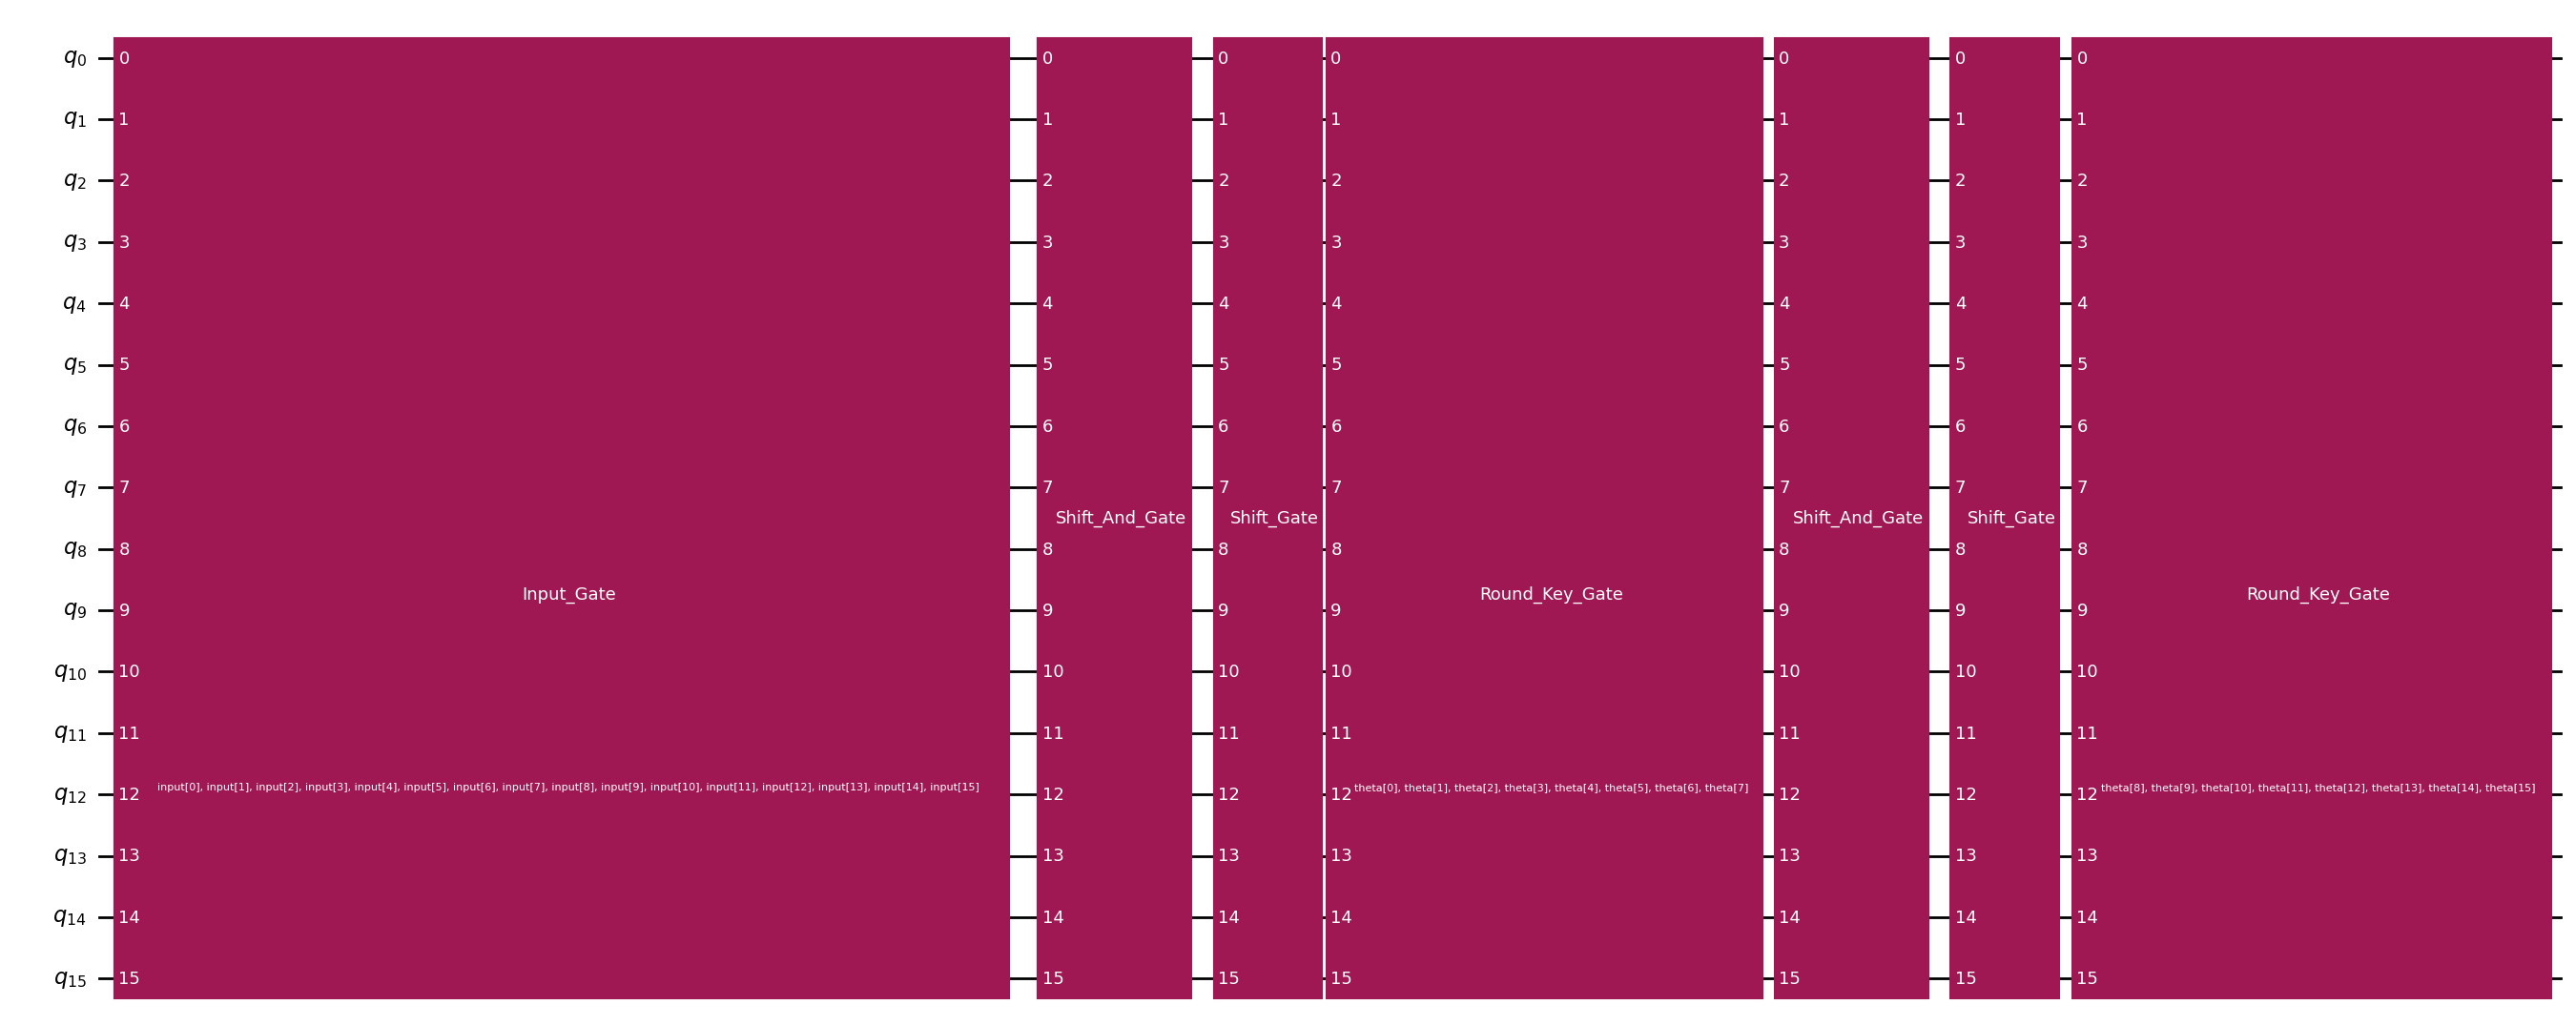

In [ ]:
class QuantumFeistelNetwork(QuantumCircuit):
    """
    Implements a Quantum Feistel Network (QFN) using Qiskit.

    A QFN is a structure for constructing quantum cryptographic algorithms
    based on Feistel networks, allowing for operations on qubits
    through a series of rounds, shifts, and gate operations.
    """
    def __init__(self, num_qubits, reps, shift1=1, shift2=8, shift3=2):
        super().__init__(num_qubits)
        if num_qubits % 2:
            raise ValueError("Bit length should be even")
        self.len = num_qubits
        self.half_len = num_qubits // 2
        self.reps = reps
        self.shift1, self.shift2, self.shift3 = shift1, shift2, shift3
        self.input = ParameterVector('input', self.len)
        self.params = ParameterVector('theta', self.half_len * reps)
        self.cache = {'mc_gate_index': {}, 'c_gate_index': {}}

    @staticmethod
    def _left_rotate(length, shift):
        shift %= length
        order = list(range(length - 1, -1, -1))  # Match Qiskit qubit ordering
        return order[shift:] + order[:shift]

    def _get_shift_bias(self, round_num):
        return self.half_len if round_num % 2 == 1 else 0

    def _get_MCGate_index(self, round_num, shift1=None, shift2=None):
        shift1 = shift1 or self.shift1
        shift2 = shift2 or self.shift2
        bias = self._get_shift_bias(round_num)
        key = (bias, shift1, shift2)

        if key not in self.cache['mc_gate_index']:
            order1, order2 = self._left_rotate(self.half_len, shift1), self._left_rotate(self.half_len, shift2)
            control_index = [[bias + a, bias + b] for a, b in zip(order1, order2)]
            target_index = [self.len - bias - idx - 1 for idx in range(self.half_len)]
            self.cache['mc_gate_index'][key] = (target_index, control_index)
        return self.cache['mc_gate_index'][key]

    def _get_CGate_index(self, round_num, shift=None):
        shift = shift or self.shift3
        bias = self._get_shift_bias(round_num)
        key = (bias, shift)
        if key not in self.cache['c_gate_index']:
            order = self._left_rotate(self.half_len, shift)
            control_index = [bias + a for a in order]
            target_index = [self.len - bias - idx - 1 for idx in range(self.half_len)]
            self.cache['c_gate_index'][key] = (target_index, control_index)
        return self.cache['c_gate_index'][key]

    def Shift_And_Gate(self, round_num, shift1=None, shift2=None):
        target_idx_list, control_idx_list = self._get_MCGate_index(round_num, shift1, shift2)
        qc = QuantumCircuit(self.len, name="Shift_And_Gate")
        for target_idx, control_idx in zip(target_idx_list, control_idx_list):
            qc.mcx(control_idx, target_idx)
        return qc.to_gate()

    def Shift_Gate(self, round_num, shift=None):
        target_idx_list, control_idx_list = self._get_CGate_index(round_num, shift)
        qc = QuantumCircuit(self.len, name="Shift_Gate")
        for target_idx, control_idx in zip(target_idx_list, control_idx_list):
            qc.cx(control_idx, target_idx)
        return qc.to_gate()

    def Round_Key_Gate(self, round_num):
        bias = self._get_shift_bias(round_num)
        qc = QuantumCircuit(self.len, name="Round_Key_Gate")
        for i in range(self.half_len):
            qc.rx(self.params[round_num * self.half_len + i], i + bias)
        return qc.to_gate()

    def Input_Gate(self):
        qc = QuantumCircuit(self.len, name="Input_Gate")
        for i in range(self.len):
            qc.rx(math.pi * self.input[i], i)
        return qc.to_gate()


class Simon(QuantumFeistelNetwork):
    def __init__(self, num_bytes, reps):
        """Initialize Simon cipher circuit.

        Args:
            num_bytes (int): Number of bytes in the cipher input.
            reps (int): Number of rounds in the cipher.
            name (str): Name of the cipher instance.
        """
        num_qubits = num_bytes * 8
        super().__init__(num_qubits, reps)

        self.name = "Simon"

        # Apply initial input gate
        self.append(self.Input_Gate(), range(self.len))

        # Apply shift, and, and round key gates for each round
        for round_id in range(self.reps):  # reps represents rounds in cipher
            self.append(self.Shift_And_Gate(round_id), range(self.len))
            self.append(self.Shift_Gate(round_id), range(self.len))
            self.append(self.Round_Key_Gate(round_id), range(self.len))


qc = Simon(num_bytes=2, reps=2)
qc.draw('mpl', fold=-1)

2.  Approach round-key via qiskit_machine_learning

In [ ]:
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit_machine_learning.gradients import ParamShiftEstimatorGradient



if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Using GPU: {torch.cuda.get_device_name(0)}')
else:
    device = torch.device('cpu')
    print('Using CPU')


class SimonDecipher(nn.Module):
    def __init__(self, num_bytes, reps):
        super().__init__()
        estimator = Estimator()
        simon = Simon(num_bytes, reps)
        pqc = EstimatorQNN(
            circuit = simon,
            input_params = simon.input,
            weight_params = simon.params,
            estimator = estimator,
            observables = [SparsePauliOp('I' * i + 'Z' + 'I' * (num_bytes*8- i - 1)) for i in range(num_bytes*8)]
        )
        self.qnn = TorchConnector(pqc)

    def forward(self, input_data):
        with torch.no_grad():
          out = self.qnn.forward(input_data)
        return out

Using CPU


In [ ]:
def generate_random_hex_list(num_samples, num_bits=16):
    max_val = (2 ** num_bits) - 1  # 16 bits -> 0xFFFF
    return [random.randint(0, max_val) for _ in range(num_samples)]


def hex_to_binary_tensor(hex_values, num_bits=16):
    tensor_list = []
    for hex_val in hex_values:
        if isinstance(hex_val, str):
            hex_val = hex_val.replace('0x', '').replace('0X', '')
            int_val = int(hex_val, 16)
        else:
            int_val = int(hex_val)

        binary_str = format(int_val, f'0{num_bits}b')
        bits = [int(bit) for bit in binary_str]
        tensor_list.append(torch.tensor(bits, dtype=torch.float32))

    return torch.stack(tensor_list)

def generate_cipher_pairs(simon_cipher, plaintexts):
    """Generates ciphertexts for a given list of plaintexts using the Simon cipher.

    Args:
        simon_cipher: An initialized Simon cipher object instance.
        plaintexts: A list or iterable of plaintexts to be encrypted.

    Returns:
        (tensors, tensors)
    """
    ciphertexts = []
    for plaintext in plaintexts:
        ciphertext = simon_cipher.encrypt(plaintext)
        ciphertexts.append(ciphertext)

    return hex_to_binary_tensor(plaintexts), hex_to_binary_tensor(ciphertexts)


def generate_simon_dataset(simon_cipher, num_samples, num_bits=16):
    plaintexts = generate_random_hex_list(num_samples, num_bits)
    plaintexts, ciphertexts = generate_cipher_pairs(simon_cipher, plaintexts)
    return plaintexts, ciphertexts

def create_simon_dataloaders(simon_cipher, train_samples, test_samples,
                           batch_size=32, num_bits=16):
    train_data, train_target = generate_simon_dataset(simon_cipher, train_samples, num_bits)
    test_data, test_target = generate_simon_dataset(simon_cipher, test_samples, num_bits)

    train_dataset = TensorDataset(train_data, train_target)
    test_dataset = TensorDataset(test_data, test_target)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

    return train_dataloader, test_dataloader

In [ ]:
@torch.no_grad()
def train_model_with_SPSA(num_epoch=100):
    optimizer = SPSA(model.parameters())  # backwardprop is slow
    loss_list = []

    model.train()
    for epoch in range(num_epoch):
        for datas, targets in train_dataloader:
            #datas, targets = datas.to(device), targets.to(device)
            outputs = model(datas)
            #print(outputs)
            #print(targets)
            loss = criterion(outputs, targets)
            loss_list.append(loss.item())

            def closure():
                outputs = model(datas)
                return criterion(outputs, targets)

            optimizer.step(closure)

        print(f'Epoch {epoch+1}, Loss: {loss.item()}') if (epoch+1) % 10 == 0 else None


    plt.plot(loss_list, label="SPSA on Simon")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.show()



@torch.no_grad()
def train_model_with_SA(num_epoch=100):
    sampler = MultiMethodSampler(bounds=(0, 1), batch_size=20, beta=0.7, dAlembert_ratio=(0.001, 0.5))  # 0~pi
    schedule = SharkTeethAnnealing(initial_temp=100.0, cooling_rate=0.45, annealing_period=100, frequency_exponent=1.01)

    optimizer = GuidedSA(
        model.parameters(),
        sampler=sampler,
        schedule=schedule,
        best_memory_size=10,
        T_greedy=10,
        T_tunnel=70,
        target_loss=1e-4,
        #sobol=False
    )

    loss_list = []

    model.train()
    for epoch in range(num_epoch):
        for datas, targets in train_dataloader:
            #datas, targets = datas.to(device), targets.to(device)

            def closure():
                outputs = model(datas)
                return criterion(outputs, targets)
            optimizer.step(closure)

            best_loss = optimizer.get_best_result()
            loss_list.append(best_loss)

        print(f'Epoch {epoch+1}, Loss: {best_loss}') if (epoch+1) % 10 == 0 else None

    plt.plot(loss_list, label="Loss per Step")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.show()

In [ ]:
simon_cipher = SimonCipher(key=0x1918, key_size=32, block_size=16)
train_dataloader, test_dataloader = create_simon_dataloaders(simon_cipher, train_samples=2, test_samples=1, num_bits=16)

num_bytes = 2
number_round = 16
model = SimonDecipher(num_bytes, number_round).to(device)

criterion = nn.MSELoss()

Epoch 10, Loss: 0.34493011236190796
Epoch 20, Loss: 0.34605157375335693
Epoch 30, Loss: 0.34178683161735535
Epoch 40, Loss: 0.3436524569988251
Epoch 50, Loss: 0.3407098948955536
Epoch 60, Loss: 0.3399408459663391
Epoch 70, Loss: 0.347834974527359
Epoch 80, Loss: 0.3446599245071411
Epoch 90, Loss: 0.34094473719596863
Epoch 100, Loss: 0.341663658618927
Epoch 110, Loss: 0.33954888582229614
Epoch 120, Loss: 0.3350364565849304
Epoch 130, Loss: 0.3373466730117798
Epoch 140, Loss: 0.34210988879203796
Epoch 150, Loss: 0.33791229128837585
Epoch 160, Loss: 0.34439900517463684
Epoch 170, Loss: 0.34036532044410706
Epoch 180, Loss: 0.34398993849754333
Epoch 190, Loss: 0.34114813804626465
Epoch 200, Loss: 0.3478948175907135
Epoch 210, Loss: 0.3421889543533325
Epoch 220, Loss: 0.3454582691192627
Epoch 230, Loss: 0.34796449542045593
Epoch 240, Loss: 0.34369489550590515
Epoch 250, Loss: 0.3472823202610016
Epoch 260, Loss: 0.3376818001270294
Epoch 270, Loss: 0.3439216613769531
Epoch 280, Loss: 0.3436202

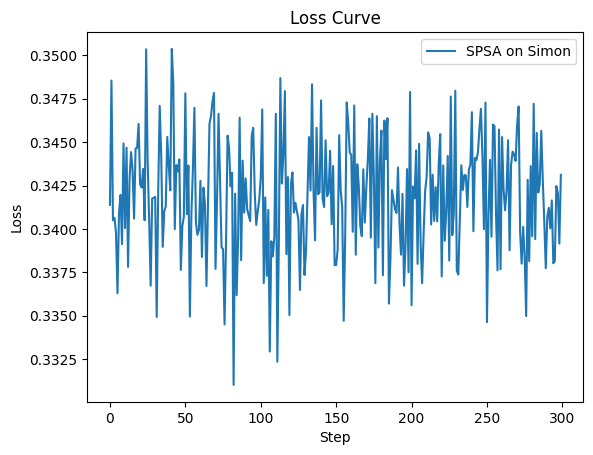

In [ ]:
train_model_with_SPSA(300)

Not surprise that SPSA can't solve it since it has a complex landscape.

Epoch 10, Loss: 0.39745479822158813
Epoch 20, Loss: 0.39745479822158813
Epoch 30, Loss: 0.39564913511276245
Epoch 40, Loss: 0.39564913511276245
Epoch 50, Loss: 0.39564913511276245
Epoch 60, Loss: 0.39498892426490784
Epoch 70, Loss: 0.39498892426490784
Epoch 80, Loss: 0.3940010666847229
Epoch 90, Loss: 0.3940010666847229
Epoch 100, Loss: 0.39221295714378357


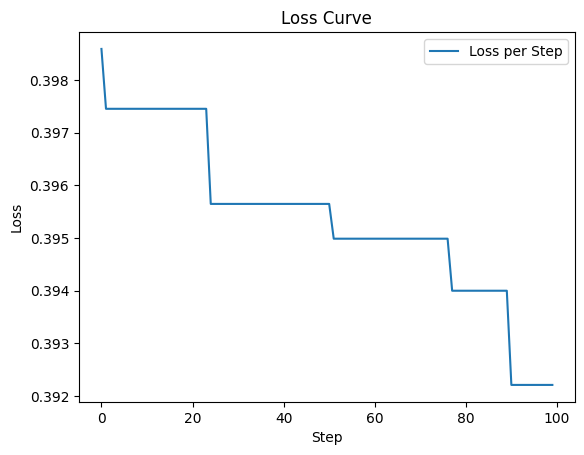

In [ ]:
train_model_with_SA()

It takes too much time on simulation, and even my optimizer can't really solve this effectively.

In [ ]:
simon_cipher = SimonCipher(key=0x1918, key_size=16, block_size=16)
train_dataloader, test_dataloader = create_simon_dataloaders(simon_cipher, train_samples=2, test_samples=1, num_bits=16)

num_bytes = 2
number_round = 4
model = SimonDecipher(num_bytes, number_round).to(device)

criterion = nn.MSELoss()

Epoch 10, Loss: 0.6740561723709106
Epoch 20, Loss: 0.6733324527740479
Epoch 30, Loss: 0.6495451927185059
Epoch 40, Loss: 0.6495451927185059
Epoch 50, Loss: 0.6147263050079346
Epoch 60, Loss: 0.5873873233795166
Epoch 70, Loss: 0.5873873233795166
Epoch 80, Loss: 0.5873873233795166
Epoch 90, Loss: 0.5873873233795166
Epoch 100, Loss: 0.5700204372406006


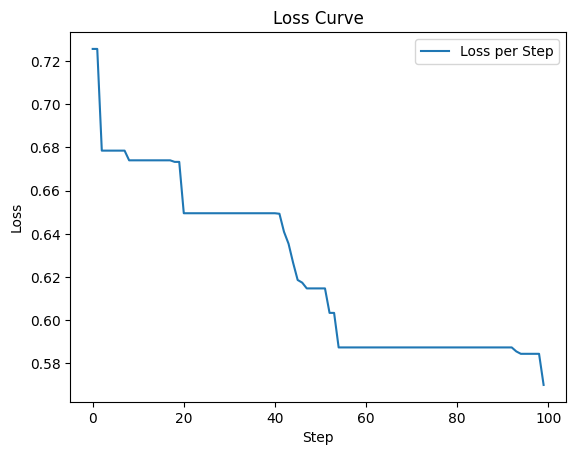

In [ ]:
train_model_with_SA()

And it's trivial that it's easier to converge with less round.



##  AES

一般而言約10~20 cpb(cycles per byte)，但有指令集支援或硬體加速下則可到 3以下

單輪流程如下:

1.   AddRoundKey: 將 input與 round key做 xor( GF(2^N) 上的加法)
2.   SubBytes: 對各 byte做 GF(2^8)上的 affine transform，提供 GF(2^8)上的非線性

3.   ShiftRows: 將 input分為數組 4*4bytes 方陣，在各 row中做 byte次序調換
4.   MixColumns:  將上述 byte方陣做一次固定的矩陣乘法，產生 output(按元素次序)


依規定，運算會重複至少重複10輪



note: key有自身的 Key Expansion algorithm，也是一個遞迴算法來產生各輪金鑰(round key, 4*4 bytes)。步驟大致是將前次金鑰最後 1筆4 bytes做 left rotation與 SubBytes 產生新的第一筆4 bytes，接著xor前次輪金鑰第2筆，遞迴xor產生第3筆...最後組出下組輪金鑰。


